## Prediction of Subscription to a Game-related Newsletter


## Introduction

Minecraft is a sandbox video game where players explore and build in a world made of blocks. In this world of infinite possibilities, we would like to analyze the relationship between player behaviors and their demographics. This data was collected by a Computer Science research group at UBC led by Frank Wood. The method in which they collected data was recording players' actions throughout the world in their Minecraft servers. They provide two data sets, one of player data that contains a list of unique players and their data, and another that contains a list of individual game sessions made by each player. Specifically, we would like to know what Minecraft player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how each player differs from each other.
### Question:
Can the variables of hours played, number of sessions played and age predict whether or not a Minecraft player will subscribe to a game-related newsletter?

We will be using both datasets to explore this question. The players.csv data contains the list of players, 196, and seven variables for each player. The variables are subscribe, gender, age, name, played_hours, hashedEmail, and experience. To predict whether a player has subscribed we will use the quantitative variables of age and played_hours. We will also use sessions.csv which records each session played for a total of 1535 observations. The sessions data includes the same hashedEmail identifier as players.csv, start time and end time, as well as original start and end time. The only information we will take from sessions.csv is the number of occurrences of each hashedEmail which can also be interpreted as the number of sessions a player has played.

- The subscribe variable is categorical and contains 2 possible values: "TRUE" or "FALSE". This shows whether a player has subscribed to a game related newsletter or not.


- The played_hours variable is numeric and up to 1 decimal place. This variable, quantified in hours, was determined through how many total hours a player has logged.


- The age variable is numeric and contains integer values. This variable is the age of the player.

A noticeable issue is that this data contains some outliers in the played_hours variable. Some players have claimed to play over 200 hours of Minecraft in a single session. These points may affect the classification model in predictions. 



## Methods & Results

First we need to load in both dataset and wrangle them separately. For the session.csv data we will group the 1535 observations by the hashedEmail variable to find the number of sessions each individual has played. For players.csv we will change the variable name 'Age' to 'age' to follow a consistent naming pattern, change the subscribe variable to a factor datatype, and deselect the variables we do not need such as name, experience, and gender. From here we can merge the two datasets and deselect the hashedEmail as it will no longer be needed. 

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(scales)
library(cowplot)
library(themis)
options(repr.matrix.max.rows = 6) # i got these loading steps from other assignments we've done. im not really sure
#source('cleanup.R') # if they are all necesary tho so feel free to remove

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [13]:
# loading in datasets
players = read_csv("data/players.csv")
sessions = read_csv("data/sessions.csv")

# combining the observations so that each hashedEmail has the number of sessions played beside it
indiv_sessions <- sessions |> 
group_by(hashedEmail) |>
summarize(sessions_played = n()) 

#data wrangling for players
predictor_data <- players |>
    mutate(age = Age,
          subscribe = as.factor(subscribe)) |>
    select(-experience, -name, -gender, -Age) |>
    drop_na()

complete_data <- merge(x = predictor_data, y = indiv_sessions, by = "hashedEmail")
minecraft_data <- select(complete_data, -hashedEmail)
minecraft_data 

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


subscribe,played_hours,age,sessions_played
<fct>,<dbl>,<dbl>,<int>
TRUE,1.5,20,2
FALSE,0.4,21,1
TRUE,0.1,17,1
⋮,⋮,⋮,⋮
TRUE,56.1,23,310
TRUE,0.1,17,1
TRUE,1.1,20,1


### Summary:

In [23]:
subscribed_true <- minecraft_data |>
filter(subscribe == TRUE) |>
nrow()
subscribed_false <- minecraft_data |>
filter(subscribe == FALSE) |>
nrow()

true_prop <- subscribed_true/123 * 100
false_prop <- subscribed_false/123 * 100
true_prop
false_prop

# summary statistics 
minecraft_summary_table = minecraft_data |>
        summarize(
            # played_hours stats
                min_played_hours = min(played_hours, na.rm = TRUE),
                max_played_hours = max(played_hours, na.rm = TRUE),
                mean_played_hours = mean(played_hours, na.rm = TRUE),
            # age stats
                min_age = min(age, na.rm = TRUE),
                max_age = max(age, na.rm = TRUE),
                mean_age = mean(age, na.rm = TRUE),
            # sessions_played stats
                min_sessions = min(sessions_played, na.rm = TRUE),
                max_sessions = max(sessions_played, na.rm = TRUE),
                mean_sessions = mean(sessions_played, na.rm = TRUE)
            ) |>
  pivot_longer(
    cols = everything(),
    names_to = c("variable", "statistic"),
    names_sep = "_",
    values_to = "value"
  ) |>
  pivot_wider(
    names_from = statistic,
    values_from = value
  ) 

minecraft_summary_table <- minecraft_summary_table |>
  rename(
    Played_Hours     = played,
    Player_Age       = age,
    Sessions_Played  = sessions
  )
minecraft_summary_table 

[1] 73.98374

[1] 26.01626

Warning message:
“Expected 2 pieces. Additional pieces discarded in 3 rows [1, 2, 3].”


variable,Played_Hours,Player_Age,Sessions_Played
<chr>,<dbl>,<dbl>,<dbl>
min,0.000000,9.00000,1.00000
max,223.100000,58.00000,310.00000
mean,9.313008,21.58537,12.46341


The following is a scatterplot of minecraft_data. This provides a rough idea for the variables that correspond to either subscribing or not subscribing to the newsletter.

Warning message in scale_x_log10(labels = label_comma()):
“log-10 transformation introduced infinite values.”


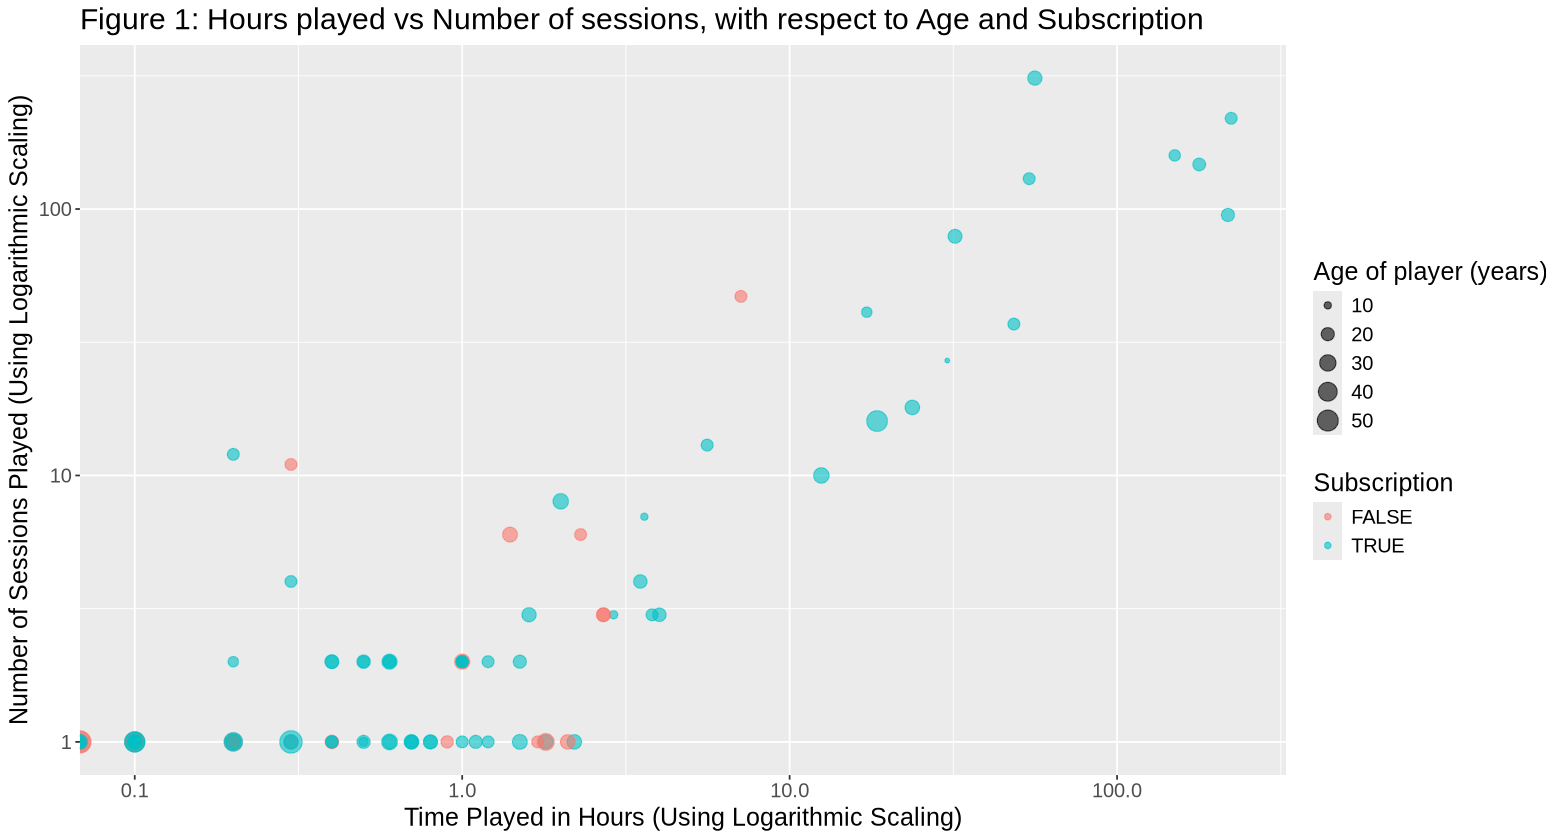

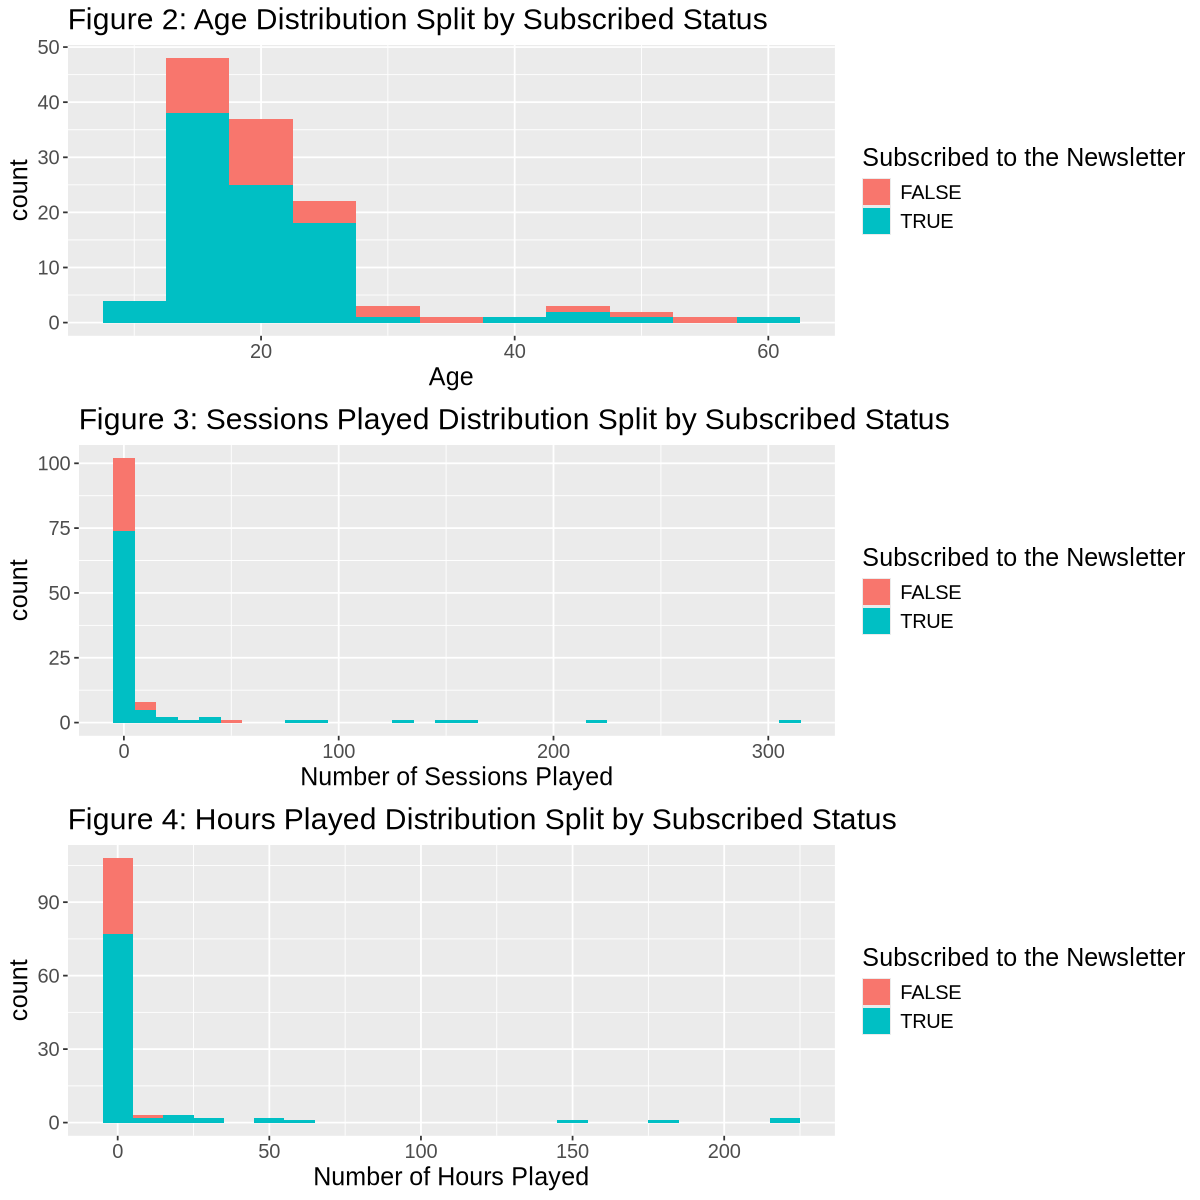

In [4]:
options(repr.plot.width = 13)
clean_data_plot <- minecraft_data |>
    ggplot(aes(x = played_hours, y = sessions_played, size = age, colour = subscribe)) +
    geom_point(alpha = 0.6) +
    labs(x = "Time Played in Hours (Using Logarithmic Scaling)", 
         y = "Number of Sessions Played (Using Logarithmic Scaling)", 
         size = "Age of player (years)", 
         colour = "Subscription") +
    ggtitle("Figure 1: Hours played vs Number of sessions, with respect to Age and Subscription") +
    scale_x_log10(labels = label_comma()) +
    scale_y_log10(labels = label_comma()) +
    theme(text = element_text(size = 15))
clean_data_plot

histogram_age <- minecraft_data |>
    ggplot(aes(x = age, fill = subscribe)) +
    geom_histogram( binwidth = 5) +
    labs(x = "Age", 
         fill = "Subscribed to the Newsletter") +
    ggtitle("Figure 2: Age Distribution Split by Subscribed Status") +
    theme(text = element_text(size = 15))

histogram_sessions <- minecraft_data |>
    ggplot(aes(x = sessions_played, fill = subscribe)) +
    geom_histogram(binwidth = 10) +
    labs(x = "Number of Sessions Played", 
         fill = "Subscribed to the Newsletter") +
    ggtitle("Figure 3: Sessions Played Distribution Split by Subscribed Status") +
    theme(text = element_text(size = 15))

histogram_hours <- minecraft_data |>
    ggplot(aes(x = played_hours, fill = subscribe)) +
    geom_histogram(binwidth = 10) +
    labs(x = "Number of Hours Played", 
         fill = "Subscribed to the Newsletter") +
    ggtitle("Figure 4: Hours Played Distribution Split by Subscribed Status") +
    theme(text = element_text(size = 15))

options(repr.plot.width = 10, repr.plot.height = 10) 
plot_grid(histogram_age, histogram_sessions, histogram_hours, nrow = 3)


Doing a summary and visualizing the dataset we found that there was an uneven distribution for all of the explanatory variables. The minimum amount of played hours was 0, the max was 223.1 and the mean was 9.3. The sessions minimum was 1, the max was 310, and the average was 12.5. Age was the least variable with the minimum being 9, max being 58, and mean being 21.6. The figure 3 and figure 4 histograms show how the majority of players have played very few sessions and hours but that does not effect their likelyhood to be subscribed to the newsletter. The scatter plot in figure 1 shows that the majority of players are subscribed and our summary reveals that the number 74% of players have subscribed.

Now we can start our analysis by tuning and training our model. We will spilt the data into 75% training and 25% testing and specify that we are using subscribe as our strata variable. Now using minecraft_training we can create a recipe that standardizes the data by oversampling the 'FALSE' observation because as we noted earlier it is less common than the 'TRUE' observation. To find the most accurate K value, we set neighbors to the tune() function and did five fold cross validations testing for K values ranging from 1-20.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6305814,5,0.04440425,Preprocessor1_Model01
2,accuracy,binary,0.6305814,5,0.04440425,Preprocessor1_Model02


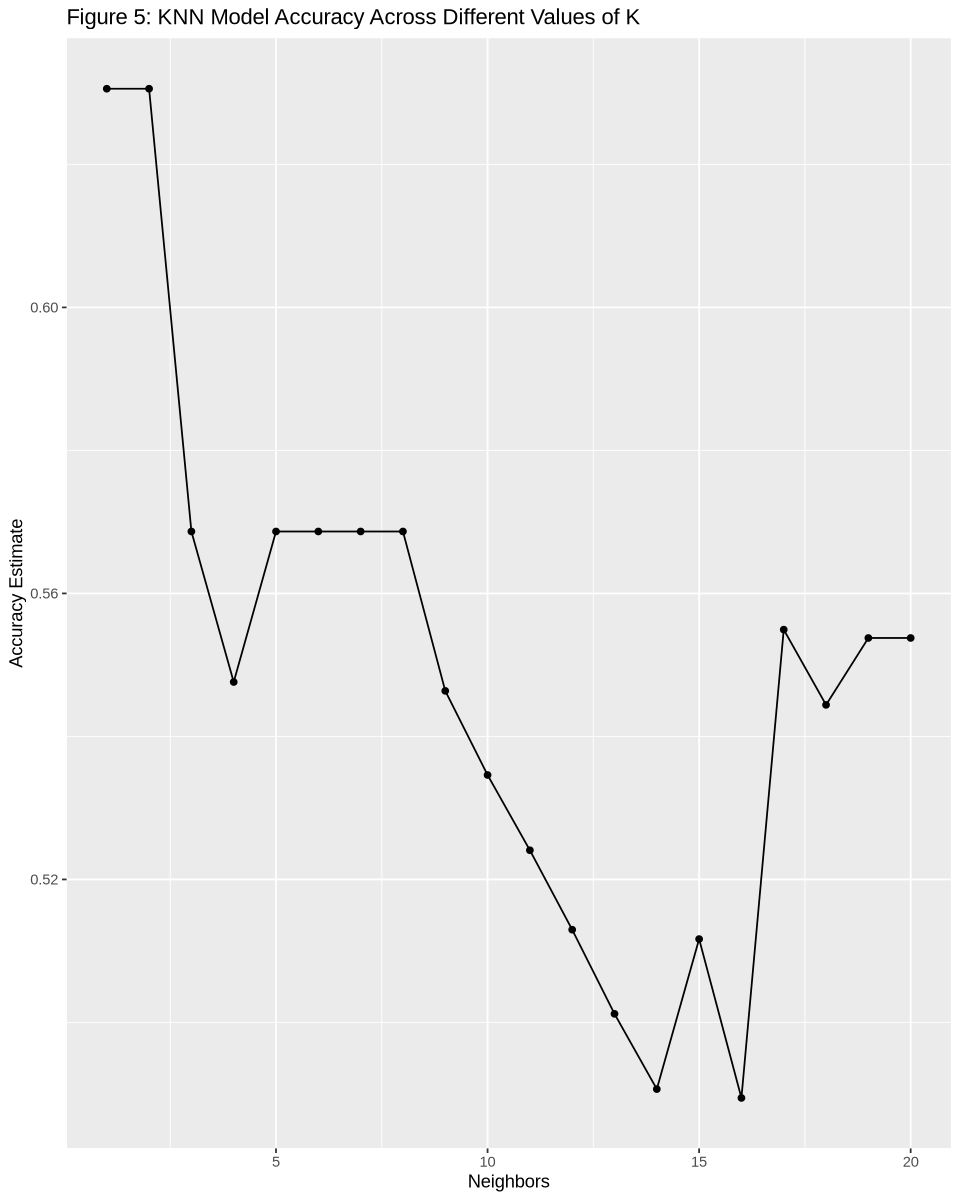

In [5]:
set.seed(1243)

minecraft_split <- initial_split(minecraft_data, prop = 0.75, strata = subscribe)  
minecraft_train <- training(minecraft_split)   
minecraft_test <- testing(minecraft_split)

minecraft_recipe_upsample <- recipe(subscribe ~., data = minecraft_train) |>
    step_scale(all_predictors())|>
    step_center(all_predictors()) |>
    step_upsample(subscribe, over_ratio = 1, skip = TRUE) 

knn_tune <- nearest_neighbor(weight_func = 'rectangular' , neighbors = tune()) |>
      set_engine('kknn') |>
      set_mode('classification') 

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

minecraft_vfold <- vfold_cv(minecraft_train, v = 5, strata = subscribe)

knn_results <- workflow() |>
      add_recipe(minecraft_recipe_upsample) |>
      add_model(knn_tune) |>
      tune_grid(resamples = minecraft_vfold, grid = k_vals) |>
      collect_metrics()

options(repr.plot.width = 8)
accuracies <- knn_results |> 
      filter(.metric == 'accuracy') 

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      ggtitle('Figure 5: KNN Model Accuracy Across Different Values of K')
accuracy_versus_k 

best_k <- slice_max(accuracies, order_by= mean, n=1)
best_k

The accuracy of K is visualized on the plot above and we can and use the slice_max function to find that the best value for K is 1 or 2. Using our knowledge from the course we know that a very low K can overfit a model so we will choose two as the K value. Knowing this we can retrain the model with the real value of K and use the same recipe.

In [6]:
minecraft_recipe <- recipe(subscribe ~., data = minecraft_train) |>
    step_scale(all_predictors())|>
    step_center(all_predictors()) 

knn <- nearest_neighbor(weight_func = 'rectangular' , neighbors = 2) |>
      set_engine('kknn') |>
      set_mode('classification')

knn_fit <- workflow() |>
      add_recipe(minecraft_recipe_upsample) |>
      add_model(knn) |>
      fit(data = minecraft_train)

Now having the fully trained model we can predict the values of the testing set and attempt to evaluate accuracy.

In [7]:
test_predictions <- predict(knn_fit, minecraft_test) |>
bind_cols(minecraft_test) 

data_for_plot <- test_predictions |>
mutate(predicted_correct = .pred_class == subscribe)
data_for_plot

metrics <- test_predictions |>
    metrics(truth = subscribe, estimate = .pred_class)  |>
    filter(.metric == "accuracy")
metrics

matrix <- test_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class)
matrix

.pred_class,subscribe,played_hours,age,sessions_played,predicted_correct
<fct>,<fct>,<dbl>,<dbl>,<int>,<lgl>
TRUE,TRUE,0.7,21,1,TRUE
TRUE,TRUE,0.6,19,2,TRUE
TRUE,TRUE,1.2,17,2,TRUE
⋮,⋮,⋮,⋮,⋮,⋮
FALSE,TRUE,3.8,17,3,FALSE
TRUE,TRUE,3.5,21,4,TRUE
TRUE,TRUE,1.1,20,1,TRUE


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6129032


          Truth
Prediction FALSE TRUE
     FALSE     2    6
     TRUE      6   17

Warning message in scale_x_log10(labels = label_comma()):
“log-10 transformation introduced infinite values.”


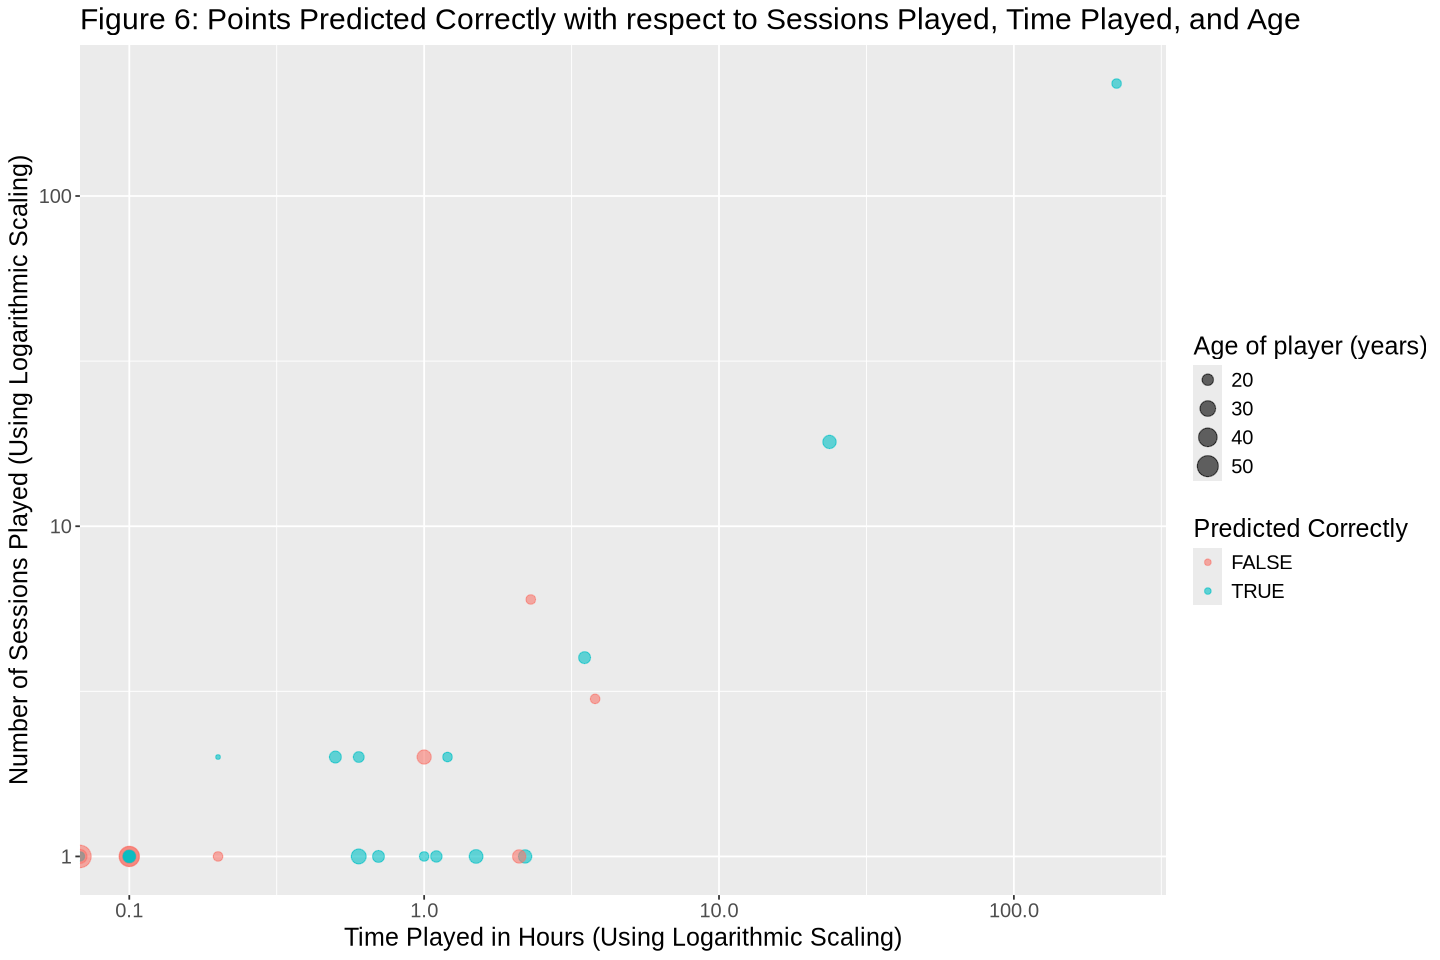

In [8]:
options(repr.plot.width = 12, repr.plot.height = 8) 
preforming_plot <- data_for_plot |>
    ggplot(aes(x = played_hours, y = sessions_played, colour = predicted_correct, size = age)) +
    geom_point(alpha = 0.6) +
    labs(x = "Time Played in Hours (Using Logarithmic Scaling)", 
         y = "Number of Sessions Played (Using Logarithmic Scaling)", 
         size = "Age of player (years)", 
         colour = "Predicted Correctly") +
    ggtitle("Figure 6: Points Predicted Correctly with respect to Sessions Played, Time Played, and Age") +
    scale_x_log10(labels = label_comma()) +
    scale_y_log10(labels = label_comma()) +
    theme(text = element_text(size = 15))
preforming_plot

Figure 3. Hours Played vs. Sessions, Colored by Prediction and Scaled by Age

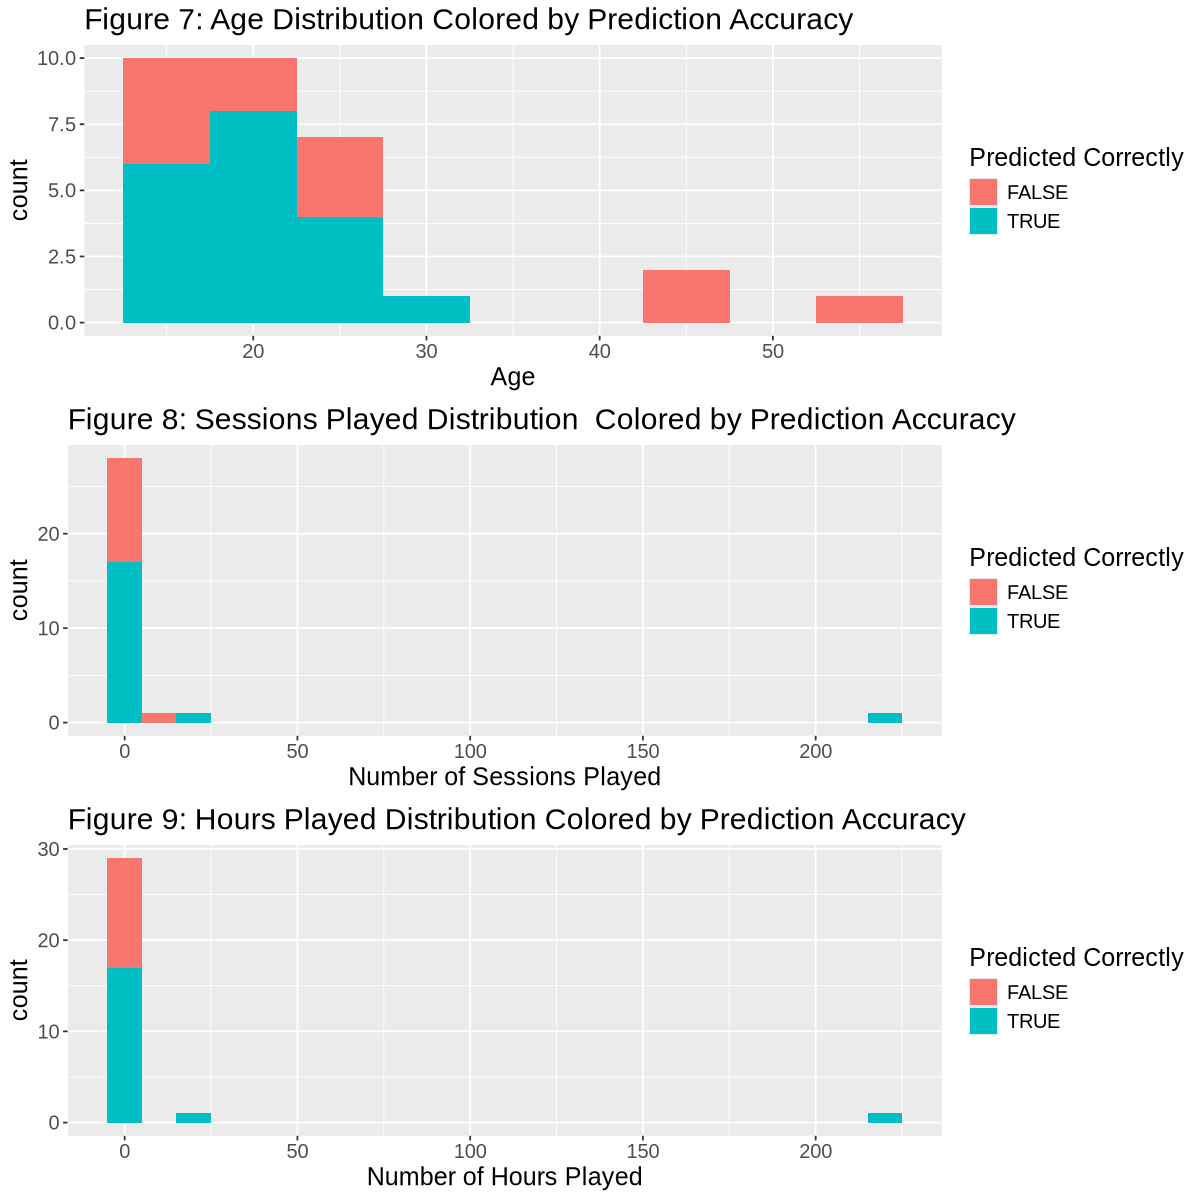

In [9]:
preformance_age <- data_for_plot |>
    ggplot(aes(x = age, fill = predicted_correct)) +
    geom_histogram(binwidth = 5) +
    labs(x = "Age", 
         fill = "Predicted Correctly") +
    ggtitle("Figure 7: Age Distribution Colored by Prediction Accuracy") +
    theme(text = element_text(size = 15))

preformance_sessions <- data_for_plot |>
    ggplot(aes(x = sessions_played, fill = predicted_correct)) +
    geom_histogram(binwidth = 10) +
    labs(x = "Number of Sessions Played", 
         fill = "Predicted Correctly") +
    ggtitle("Figure 8: Sessions Played Distribution  Colored by Prediction Accuracy") +
    theme(text = element_text(size = 15))

preformance_hours <- data_for_plot |>
    ggplot(aes(x = played_hours, fill = predicted_correct)) +
    geom_histogram(binwidth = 10) +
    labs(x = "Number of Hours Played", 
         fill = "Predicted Correctly") +
    ggtitle("Figure 9: Hours Played Distribution Colored by Prediction Accuracy")+
    theme(text = element_text(size = 15))

options(repr.plot.width = 10, repr.plot.height = 10) 
plot_grid(preformance_age, preformance_sessions, preformance_hours, nrow = 3)


## Discussion 

Across all visualizations, we found that player behaviour varies widely which makes predicting subscription status
challenging. 
The scatterplot and histograms in Figures 1-4 show that all the variables are heavily skewed, with most players 
logging very little time and only a few players showing very high engagement. Age also varies across the dataset, but most 
players are clustered around the late teens to early twenties. 
The Figure 5 KNN accuracy plot shows that the KNN model never reaches a high accuracy, staying around ~0.57 regardless of the 
number of neighbours. Although we selected K = 2 because it produced the highest accuracy, the figure still reflects overall 
weak performance across all K values. The accuracy of our test predictions was 61% with an equal amount of false positives and false negatives. The scatterplot of the prediction accuracy shows that the classifier struggled to predict observations with low sessions and hours played.
Finally, the Figure 7 age histogram suggests that prediction accuracy is inconsistent across age groups, with both correct 
and incorrect classifications appearing at most ages. 

These results were mostly what we expected. Since the dataset of numeric predictors that were selected was small and very skewed, it was not surprising that the patterns
were hard to separate. The scatterplots show a lot of overlap between subscribed and non-subscribed players, which helps 
explain why the KNN model had trouble, since people who look similar in their play habits don’t necessarily make the same 
subscription choices. The weaker model performance also makes sense, because subscribing is likely influenced by other 
factors were not measured, such as social influence or in-game spending.

These findings suggest that gameplay metrics on their own might not be enough to predict who subscribes. This matters since
companies that rely only on basic engagement stats may struggle to target and recruit more potential subscribers accurately. To get better predictions, we would likely need more detailed numeric information about player behaviour, such as how consistent their sessions are,
whether they spend money in-game, how they interact with others, or even their socioeconomic status.

These results also raise a few future questions. What other numeric features might help explain why players choose to subscribe? Would collecting a larger dataset or trying different modelling methods lead to better accuracy? And are there certain groups of players—like specific age ranges or play styles—where predictions might work better? Overall, the analysis suggests that future work should focus on gathering richer data and testing more flexible models to better understand subscription behaviour.